In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import scipy.signal
import mne

mpl.rcParams['figure.max_open_warning'] = 30

# load container for plotting
evoked = helpers.load_evoked_container(window=[0, 0.9])

Reading data/meg_final_data/evoked_sfreq100.0_window0.00-0.90_mag-ave.fif ...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Found the data of interest:
        t =       0.00 ...     890.00 ms (Unknown)
        0 CTF compensation matrices available
        nave = 480 - aspect type = 100
No baseline correction applied


In [2]:
# plotting function
times=np.linspace(0.4, 0.7, 8)
def plot_topo(data, times=np.linspace(0.4, 0.7, 8), scale=1, 
              vmin=None, vmax=None, cmap=None, unit=None, regressors=None):
    
    if regressors is None:
        regressors = data.columns
        
    for reg in regressors:
        evoked.data = data[reg].values.reshape(evoked.data.shape)
        evoked.comment = reg
    
        fig = evoked.plot_topomap(times, scale=scale, vmin=vmin, vmax=vmax, 
                                  cmap=cmap, unit=unit, image_interp='nearest', 
                                  title=reg)
        fig.set_label(reg)
        

# Note that these are not exactly the t-values underlying the negative log10 p-values 
# stored in second_level, because scipy.stats uses a different denominator when 
# computing variances and standard deviations than the default used by numpy 
# (N-1 in scipy.stats vs. N in numpy default).
def get_tvals(second_level):
    tvals = (second_level.xs('mean', axis=1, level='measure')  / 
             second_level.xs('std', axis=1, level='measure') * np.sqrt(34))
    
    return tvals

# Summary statistic approach

In [3]:
second_level = pd.read_hdf(helpers.resultsdir + '/meg_hierarchical_ss_bl_long_1to5_abs.h5', 'second_level')
tvals = get_tvals(second_level)
second_level.xs('mlog10p', axis=1, level='measure').describe()

regressor,abs_dot_x_1,abs_dot_x_2,abs_dot_x_3,abs_dot_x_4,abs_dot_x_5,abs_dot_y_1,abs_dot_y_2,abs_dot_y_3,abs_dot_y_4,abs_dot_y_5,...,dot_x_4,dot_x_5,dot_y_1,dot_y_2,dot_y_3,dot_y_4,dot_y_5,entropy,intercept,trial_time
count,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,...,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000
mean,0.614176,0.541516,0.603490,0.597571,0.607127,0.565477,0.659456,0.567166,0.612203,0.576702,...,1.100556,1.093525,0.846055,0.748163,0.651932,0.738537,0.686992,0.607421,0.836396,0.448062
std,0.621096,0.597908,0.638423,0.683213,0.653101,0.587125,0.700348,0.675024,0.682474,0.606240,...,1.471717,1.550152,1.012187,0.934528,0.890826,0.925935,0.854271,0.598629,0.900863,0.437571
min,0.000026,0.000037,0.000081,0.000058,0.000005,0.000082,0.000134,0.000063,0.000078,0.000086,...,0.000102,0.000208,0.000109,0.000099,0.000024,0.000048,0.000008,0.000130,0.000008,0.000038
25%,0.165544,0.153069,0.158654,0.153051,0.162538,0.152017,0.167505,0.144315,0.165859,0.155903,...,0.217739,0.192293,0.188624,0.176292,0.141744,0.171248,0.159160,0.171279,0.211067,0.124084
50%,0.420189,0.358774,0.389237,0.383832,0.401098,0.372887,0.421943,0.345336,0.396859,0.375284,...,0.567936,0.505680,0.480457,0.441266,0.357615,0.423337,0.394426,0.416830,0.533192,0.307404
75%,0.854056,0.722412,0.816880,0.794514,0.823857,0.774127,0.906963,0.735552,0.810821,0.785007,...,1.336332,1.262600,1.095382,0.923705,0.768008,0.938667,0.874239,0.856144,1.152562,0.627905
max,5.949560,6.956339,4.842000,8.648866,6.230198,4.774165,5.955691,8.312396,6.207324,4.556834,...,11.709714,11.720643,8.225806,8.537337,8.652841,7.574418,7.656865,4.979889,7.274184,3.159454


In [4]:
second_level_perm = pd.read_hdf(helpers.resultsdir + 
                                '/meg_hierarchical_ss_bl_long_1to5_abs_permuted.h5', 'second_level')
second_level_perm2 = pd.read_hdf(helpers.resultsdir + 
                                '/meg_hierarchical_ss_bl_long_1to5_abs_permuted2.h5', 'second_level')
second_level_perm.xs('mlog10p', axis=1, level='measure').describe()

regressor,abs_dot_x_1,abs_dot_x_2,abs_dot_x_3,abs_dot_x_4,abs_dot_x_5,abs_dot_y_1,abs_dot_y_2,abs_dot_y_3,abs_dot_y_4,abs_dot_y_5,...,dot_x_4,dot_x_5,dot_y_1,dot_y_2,dot_y_3,dot_y_4,dot_y_5,entropy,intercept,trial_time
count,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9.180000e+03,9180.000000,9180.000000,9180.000000,...,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000
mean,0.526757,0.514801,0.514789,0.475067,0.498602,0.514231,4.720119e-01,0.495854,0.499990,0.502292,...,0.512355,0.490319,0.486930,0.506296,0.471152,0.485488,0.478697,0.513366,0.819676,0.450026
std,0.535863,0.535510,0.531821,0.479440,0.514545,0.523762,4.815961e-01,0.495548,0.501035,0.510942,...,0.519496,0.500754,0.529180,0.513850,0.474540,0.494949,0.507632,0.516414,0.902239,0.449072
min,0.000010,0.000025,0.000024,0.000022,0.000015,0.000014,1.596088e-07,0.000103,0.000008,0.000007,...,0.000011,0.000075,0.000016,0.000018,0.000030,0.000173,0.000032,0.000041,0.000292,0.000047
25%,0.144254,0.140565,0.138604,0.136419,0.136437,0.139499,1.265801e-01,0.141545,0.143219,0.140331,...,0.145208,0.142760,0.133947,0.141127,0.131023,0.134688,0.127668,0.144200,0.198552,0.132361
50%,0.359443,0.343070,0.345763,0.331531,0.332317,0.345313,3.217041e-01,0.342475,0.346405,0.344925,...,0.341005,0.337933,0.320548,0.345628,0.322464,0.332714,0.314906,0.348012,0.510432,0.315900
75%,0.729811,0.708834,0.700952,0.660303,0.687001,0.711318,6.586710e-01,0.683858,0.692996,0.698075,...,0.712475,0.679200,0.651375,0.699092,0.660553,0.672363,0.652992,0.716498,1.128073,0.626841
max,4.262596,4.582904,4.085186,4.014725,4.835262,3.879890,4.947038e+00,5.886787,4.340587,4.558044,...,4.334503,4.503707,5.612510,4.321621,4.360298,4.852029,4.332941,4.355595,7.808527,4.169355


## Raw measures for selected regressors
Note that these are not exactly the t-values underlying the negative log10 p-values stored in second_level, because scipy.stats uses a different denominator when computing variances and standard deviations than the default used by numpy (N-1 in scipy.stats vs. N in numpy default).

### maximum across channels

<IPython.core.display.Javascript object>


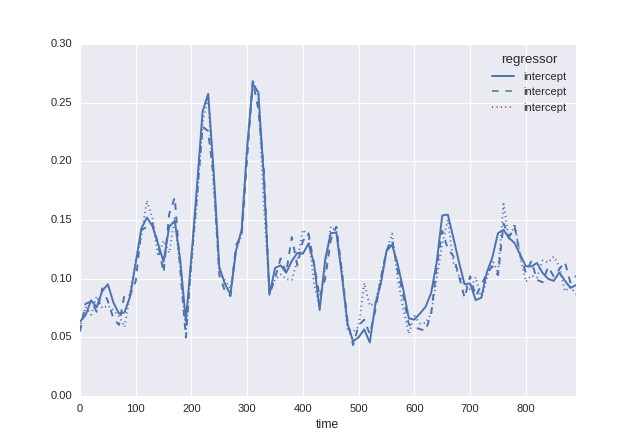

In [68]:
reg = ['intercept']
measure = 'mean'
ax = second_level.xs(measure, axis=1, level='measure').max(level='time').plot(
                     y=reg);
cols = [l.get_color() for l in ax.get_lines()]
second_level_perm.xs(measure, axis=1, level='measure').max(level='time').plot(
                     y=reg, ax=ax, style=['--'] * len(reg))
second_level_perm2.xs(measure, axis=1, level='measure').max(level='time').plot(
                      y=reg, ax=ax, style=[':'] * len(reg))
lines = ax.get_lines()
for i in range(len(reg)):
    col = lines[i].get_color()
    lines[i+len(reg)].set_color(col)
    lines[i+2*len(reg)].set_color(col)
    

<IPython.core.display.Javascript object>


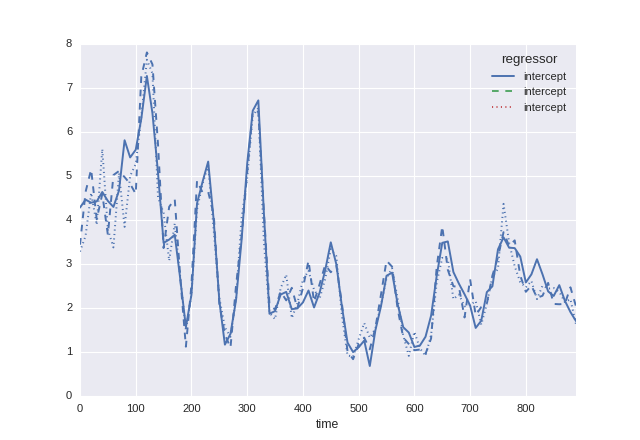

In [24]:
measure = 'mlog10p'
ax = second_level.xs(measure, axis=1, level='measure').max(level='time').plot(
                     y=reg);
cols = [l.get_color() for l in ax.get_lines()]
second_level_perm.xs(measure, axis=1, level='measure').max(level='time').plot(
                     y=reg, ax=ax, style=['--'] * len(reg))
second_level_perm2.xs(measure, axis=1, level='measure').max(level='time').plot(
                      y=reg, ax=ax, style=[':'] * len(reg))
lines = ax.get_lines()
for i in range(len(reg)):
    col = lines[i].get_color()
    lines[i+len(reg)].set_color(col)
    lines[i+2*len(reg)].set_color(col)

<IPython.core.display.Javascript object>


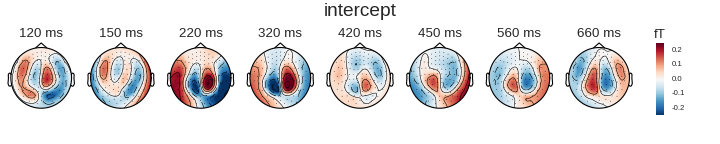

In [26]:
times = [0.12, 0.15, 0.22, 0.32, 0.42, 0.45, 0.56, 0.66]
plot_topo(second_level.xs('mean', axis=1, level='measure'), times, 
          vmin=-0.2, vmax=0.2, regressors=reg)

## Aligning effects of the different dots

In [8]:
def align_regressors(data, r_name):
    aligned = np.c_[[data.loc[d*100:d*100+490, r_name+'_%d' % (d+1)] for d in range(5)]].T
    aligned = pd.DataFrame(aligned, columns=[r_name+'_%d' % d for d in range(1, 6)], 
            index=pd.Index(np.arange(0, 500, 10), name='time after dot onset (ms)'))
    
    return aligned

def show_aligned_effects(r_name, measure):
    data = second_level.xs(measure, axis=1, level='measure').max(level='time')
    aligned = align_regressors(data, r_name)
    ax = aligned.plot(title=measure);
    ax.plot(aligned.mean(axis=1), '--', color='0', lw=2, label='mean')
    ax.legend()

    # identify local maxima
    times = aligned.index[scipy.signal.argrelextrema(aligned.mean(axis=1).values, 
                                                     np.greater, order=4)] / 1000
    
    tvals_aligned = pd.concat([align_regressors(tvals.loc[channel], r_name) 
                           for channel in tvals.index.levels[0]], 
                          keys=tvals.index.levels[0])

    ev = mne.EvokedArray(tvals_aligned.mean(axis=1).values.reshape(102, 
                             tvals_aligned.index.levels[1].size), 
                         evoked.info, tmin=tvals_aligned.index.levels[1][0], 
                         nave=480, comment=r_name)
    
    fig = ev.plot_topomap(times, scale=1, vmin=-10, vmax=10, image_interp='nearest', 
                          title=r_name+' aligned to dot onset', unit='t-val');

### dot_x

In [9]:
second_level.loc[(slice(None), 700), ('mean', 'dot_x_4')].abs().argmax()

('MEG0721', 700)

<IPython.core.display.Javascript object>


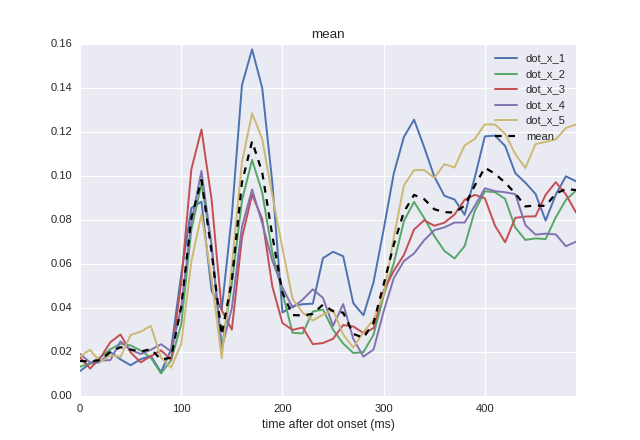

<IPython.core.display.Javascript object>


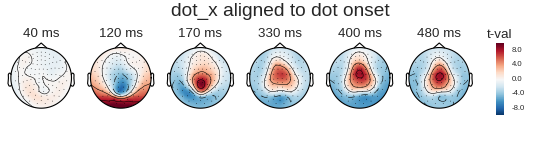

In [10]:
show_aligned_effects('dot_x', 'mean')

### dot_y

<IPython.core.display.Javascript object>


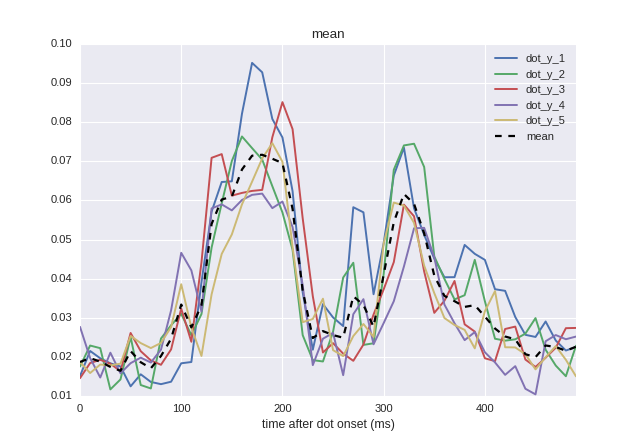

<IPython.core.display.Javascript object>


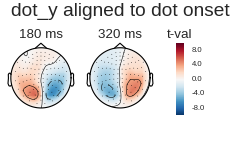

In [11]:
show_aligned_effects('dot_y', 'mean')

### Absolute dot positions (surprise)

<IPython.core.display.Javascript object>


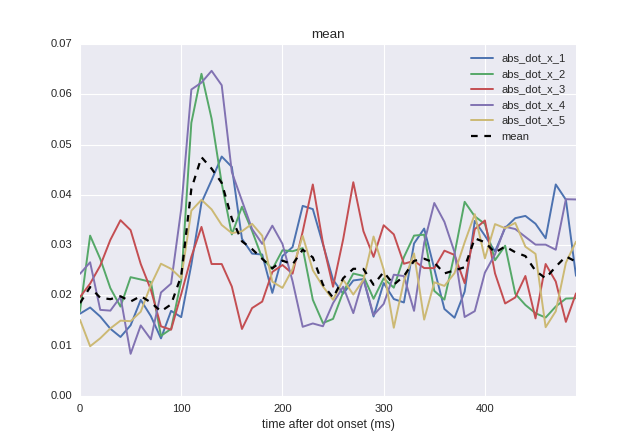

<IPython.core.display.Javascript object>


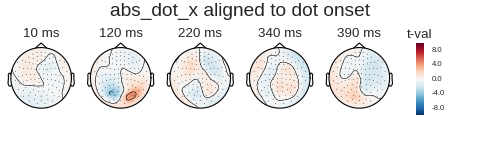

In [28]:
show_aligned_effects('abs_dot_x', 'mean')

<IPython.core.display.Javascript object>


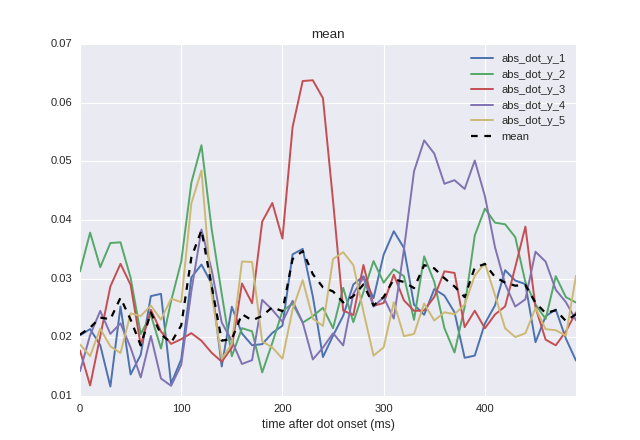

<IPython.core.display.Javascript object>


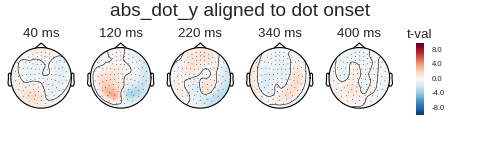

In [38]:
show_aligned_effects('abs_dot_y', 'mean')

<IPython.core.display.Javascript object>


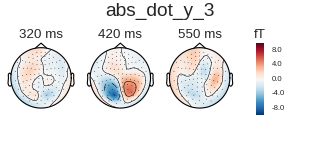

In [58]:
d = 3
times = np.r_[0.12, 0.22, 0.35] + 0.1*(d-1)
plot_topo(tvals, times, vmin=-10, vmax=10, regressors=['abs_dot_y_%d' % d])

<IPython.core.display.Javascript object>


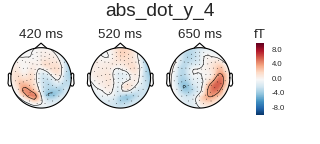

In [59]:
d = 4
times = np.r_[0.12, 0.22, 0.35] + 0.1*(d-1)
plot_topo(tvals, times, vmin=-10, vmax=10, regressors=['abs_dot_y_%d' % d])

<IPython.core.display.Javascript object>


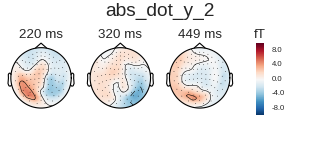

In [60]:
d = 2
times = np.r_[0.12, 0.22, 0.35] + 0.1*(d-1)
plot_topo(tvals, times, vmin=-10, vmax=10, regressors=['abs_dot_y_%d' % d])